# **Prompt Tuning**

#### 🤗 **[PEFT](https://huggingface.co/docs/peft/index)**
PEFT is a library for efficiently adapting large pretrained models to various downstream applications without fine-tuning all of a model’s parameters because it is prohibitively costly. PEFT methods only fine-tune a small number of (extra) model parameters - significantly decreasing computational and storage costs - while yielding performance comparable to a fully fine-tuned model. This makes it more accessible to train and store large language models (LLMs) on consumer hardware.

PEFT is integrated with the Transformers, Diffusers, and Accelerate libraries to provide a faster and easier way to load, train, and use large models for inference.

There are **several types of PEFT methods (soft prompting, matrix decomposition, adapters**), but they all focus on the same thing,** reduce the number of trainable parameters**. This makes it more accessible to train and store large models on consumer hardware.

#### **Soft prompts**

Training large pretrained language models is very time-consuming and compute-intensive. As they continue to grow in size, there is increasing interest in more efficient training methods such as prompting. Prompting primes a frozen pretrained model for a specific downstream task by including a text prompt that describes the task or even demonstrates an example of the task. With prompting, you can avoid fully training a separate model for each downstream task, and use the same frozen pretrained model instead. This is a lot easier because you can use the same model for several different tasks, and it is significantly more efficient to train and store a smaller set of prompt parameters than to train all the model’s parameters.

There are two categories of prompting methods:

* **hard prompts** are manually handcrafted text prompts with discrete input tokens; the downside is that it requires a lot of effort to create a good prompt
* **soft prompts** are learnable tensors concatenated with the input embeddings that can be optimized to a dataset; the downside is that they aren’t human readable because you aren’t matching these “virtual tokens” to the embeddings of a real word

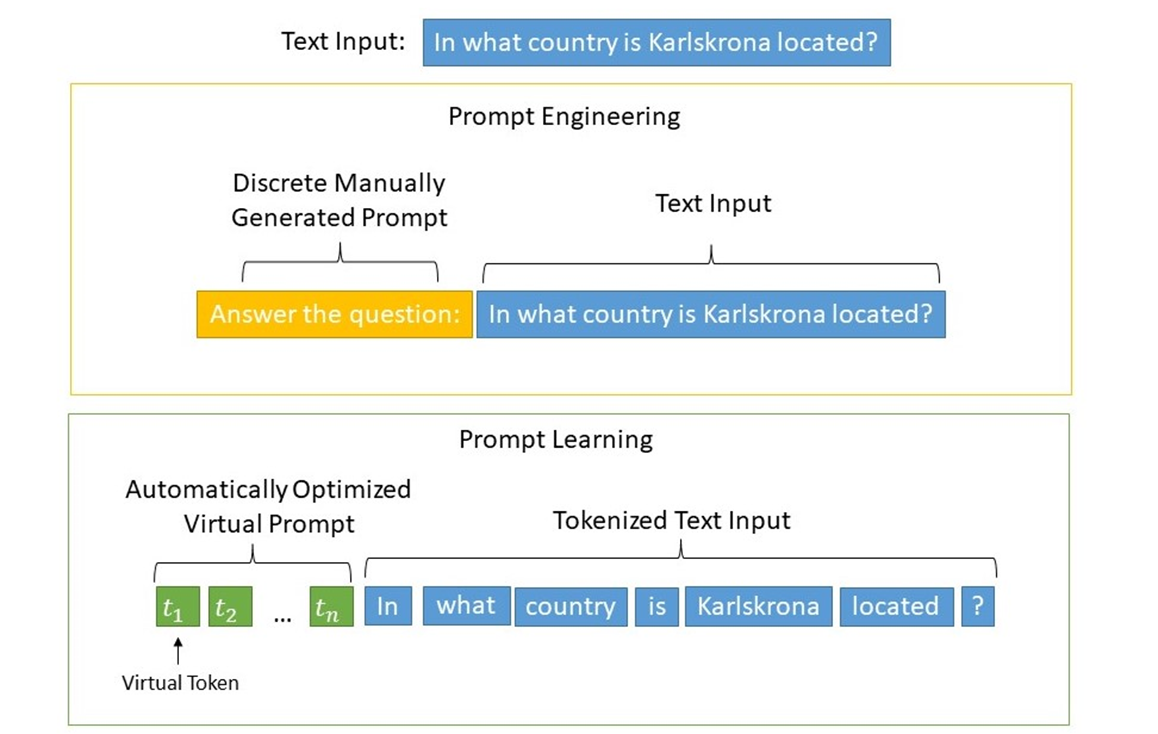

#### **Prompt tuning**
Prompt tuning was developed for text classification tasks on T5 models, and all downstream tasks are cast as a text generation task. For example, sequence classification usually assigns a single class label to a sequence of text. By casting it as a text generation task, the tokens that make up the class label are generated. Prompts are added to the input as a series of tokens. Typically, the model parameters are fixed which means the prompt tokens are also fixed by the model parameters.

**The key idea behind prompt tuning is that prompt tokens have their own parameters that are updated independently**. This means you can **keep the pretrained model’s parameters frozen, and only update the gradients of the prompt token embeddings**. The results are comparable to the traditional method of training the entire model, and prompt tuning performance scales as model size increases.

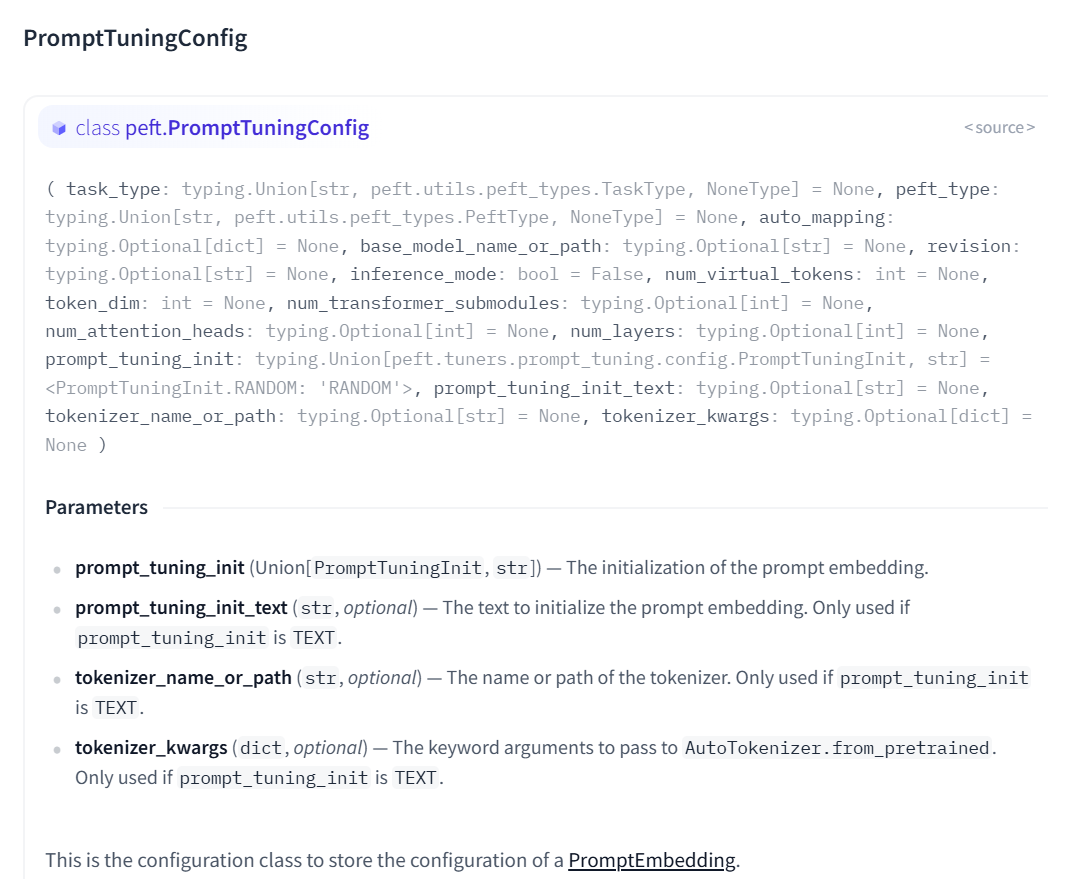

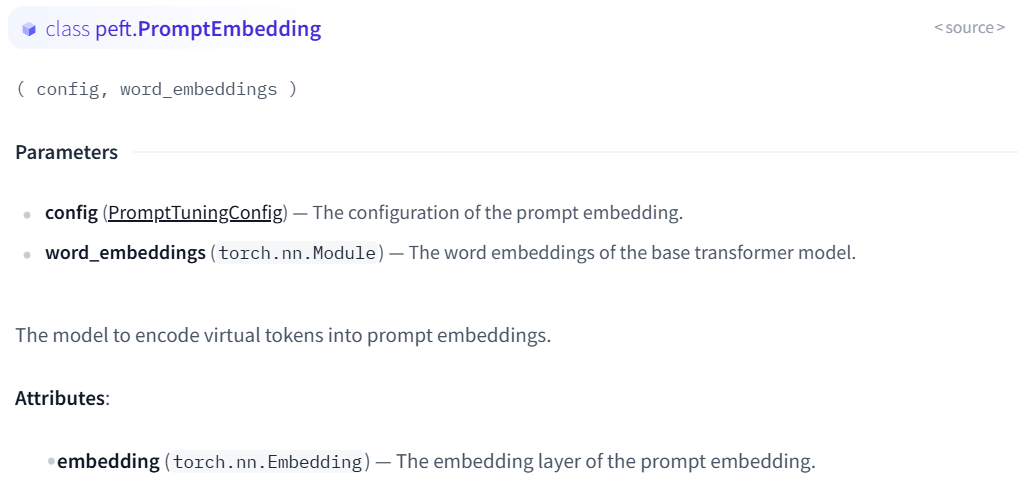

#### **Example:**
```
from peft import PromptEmbedding, PromptTuningConfig

config = PromptTuningConfig(
    peft_type="PROMPT_TUNING",
    task_type="SEQ_2_SEQ_LM",
    num_virtual_tokens=20,
    token_dim=768,
    num_transformer_submodules=1,
    num_attention_heads=12,
    num_layers=12,
    prompt_tuning_init="TEXT",
    prompt_tuning_init_text="Predict if sentiment of this review is positive, negative or neutral",
    tokenizer_name_or_path="t5-base",
)

# t5_model.shared is the word embeddings of the base model
prompt_embedding = PromptEmbedding(config, t5_model.shared)
```

* Input Shape: (batch_size, total_virtual_tokens)

* Output Shape: (batch_size, total_virtual_tokens, token_dim)

# Prompt Tuning With PEFT.

In this notebook we are introducing how to apply [prompt tuning with the PEFT library](https://huggingface.co/docs/peft/package_reference/prompt_tuning) to a pre-trained model.

For a complete list of models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models available to be trained with PEFT includes Bloom, Llama, GPT-J, GPT-2, BERT, and more. Hugging Face is working hard to add more models to the library.

## Brief introduction to Prompt Tuning.
It’s an Additive Fine-Tuning technique for models. This means that we WILL NOT MODIFY ANY WEIGHTS OF THE ORIGINAL MODEL. You might be wondering, how are we going to perform Fine-Tuning then? Well, we will train additional layers that are added to the model. That’s why it’s called an Additive technique.


In each training cycle, the only weights that can be modified to minimize the loss function are those integrated into the prompt.

The primary consequence of this technique is that the number of parameters to train is genuinely small. However, we encounter a second, perhaps more significant consequence, namely that, **since we do not modify the weights of the pretrained model, it does not alter its behavior or forget any information it has previously learned.**

The training is faster and more cost-effective. Moreover, we can train various models, and during inference time, we only need to load one foundational model along with the new smaller trained models because the weights of the original model have not been altered


# **First Example:**

## What are we going to do in the first part?
We are going to train two different models using two datasets, each with just one pre-trained model from the Bloom family. One model will be trained with a dataset of prompts, while the other will use a dataset of inspirational sentences. We will compare the results for the same question from both models before and after training.

Additionally, we'll explore how to load both models with only one copy of the foundational model in memory.


## Loading the PEFT Library
This library contains the Hugging Face implementation of various Fine-Tuning techniques, including Prompt Tuning

In [ ]:
!pip install -q peft==0.8.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.4 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets==2.14.5

From the transformers library, we import the necessary classes to instantiate the model and the tokenizer.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
import torch
from torch import nn
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from datasets import load_dataset
from peft import PromptTuningConfig, PromptTuningInit, get_peft_model, TaskType
import torch

### Loading the model and the tokenizers.

Bloom is one of the smallest and smartest models available for training with the PEFT Library using Prompt Tuning. You can choose any model from the Bloom Family, and I encourage you to try at least two of them to observe the differences.

I'm opting for the smallest one to minimize training time and avoid memory issues in Colab.

### BLOOM

**BLOOM** (short for BigScience Large Open-science Open-access Multilingual Language Model) is a large language model (LLM) developed by the BigScience research collaboration, a community-led initiative involving over 1,000 researchers from around the world.


* Architecture: Based on the Decoder Transformer architecture (similar to GPT).

* Multilingual: Trained on 46 languages and 13 programming languages.

* Size: The largest version of BLOOM has 176 billion parameters, putting it in the same class as GPT-3 (175B) and Google's PaLM.

**Use Cases:** Text generation, Summarization, Translation, Code generation, Chatbots

BLOOM is available in the following versions:

* bloom-560m
* bloom-1b1
* bloom-1b7
* bloom-3b
* bloom-7b1
* bloom (176B parameters)

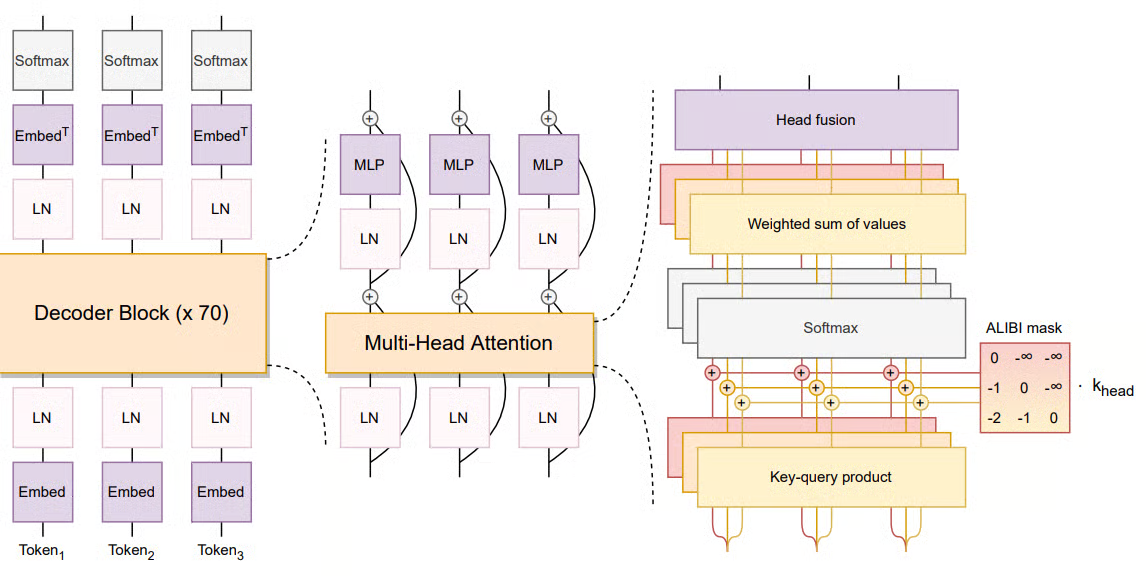

In [ ]:
model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"
NUM_VIRTUAL_TOKENS = 4
NUM_EPOCHS = 6

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
foundational_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

* AutoTokenizer.from_pretrained: Loads the tokenizer associated with the selected BLOOMZ model.

* AutoModelForCausalLM.from_pretrained: Loads the causal language model (decoder-only) for text generation.

* trust_remote_code=True: Allows loading custom model code from Hugging Face (used for models like BLOOMZ that may override internal logic).

## Inference with the pre trained bloom model
If you want to achieve more varied and original generations, uncomment the parameters: temperature, top_p, and do_sample, in *model.generate* below

With the default configuration, the model's responses remain consistent across calls.

In [ ]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        #temperature=0.2,
        #top_p=0.95,
        #do_sample=True,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs


model.generate: Performs text generation (autoregressive decoding).

max_new_tokens: Limits how many new tokens are generated.

repetition_penalty=1.5: Penalizes repeated tokens to encourage diversity.

early_stopping=True: Stops decoding if an end-of-sequence (EOS) token is likely.

eos_token_id: Specifies the EOS token.

As we want to have two different trained models, I will create two distinct prompts.

The first model will be trained with a dataset containing prompts, and the second one with a dataset of motivational sentences.

The first model will receive the prompt "I want you to act as a motivational coach." and the second model will receive "There are two nice things that should matter to you:"

But first, I'm going to collect some results from the model without Fine-Tuning.

In [ ]:
input_prompt = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt")
foundational_outputs_prompt = get_outputs(foundational_model, input_prompt, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_prompt, skip_special_tokens=True))

["I want you to act as a motivational coach.  Don't be afraid of being challenged."]


Encodes a motivational prompt as input.

Passes it to the generation function.

Prints the generated text (excluding special tokens like <pad> or <eos>).

In [ ]:
input_sentences = tokenizer("There are two nice things that should matter to you:", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundational_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['There are two nice things that should matter to you: the price and quality of your product.']


Both answers are more or less correct. Any of the Bloom models is pre-trained and can generate sentences accurately and sensibly. Let's see if, after training, the responses are either equal or more accurately generated.

## Preparing the Datasets
The Datasets useds are:
* https://huggingface.co/datasets/fka/awesome-chatgpt-prompts
* https://huggingface.co/datasets/Abirate/english_quotes


In [ ]:
import os
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
from datasets import load_dataset

dataset_prompt = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data_prompt = load_dataset(dataset_prompt)
data_prompt = data_prompt.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample_prompt = data_prompt["train"].select(range(50))


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:765: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Loads a dataset of curated prompts from Hugging Face (awesome-chatgpt-prompts).

Tokenizes each "prompt" string.

Selects the 50 entries as a small training sample.

In [ ]:
display(train_sample_prompt)

Dataset({
    features: ['act', 'prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [ ]:
print(train_sample_prompt[:1])

{'act': ['Linux Terminal'], 'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'], 'input_ids': [[44, 4026, 1152, 427, 1769, 661, 267, 104105, 28434, 17, 473, 2152, 4105, 49123, 530, 1152, 2152, 57502, 1002, 3595, 368, 28434, 3403, 6460, 17, 473, 4026, 1152, 427, 3804, 57502, 1002, 368, 28434, 10014, 14652, 2592, 19826, 4400, 10973, 15, 530, 16915, 4384, 17, 727, 1130, 11602, 184637, 17, 727, 1130, 4105, 49123, 35262, 473, 32247, 1152, 427, 727, 1427, 17, 3262, 707, 3423, 427, 13485, 1152, 7747, 361, 170205, 15, 707, 2152, 727, 1427, 1331, 55385, 5484, 14652, 6291, 999, 117805, 731, 29726, 1119, 96, 17, 26

In [ ]:
dataset_sentences = load_dataset("Abirate/english_quotes")

data_sentences = dataset_sentences.map(lambda samples: tokenizer(samples["quote"]), batched=True)
train_sample_sentences = data_sentences["train"].select(range(25))
train_sample_sentences = train_sample_sentences.remove_columns(['author', 'tags'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2508 [00:00<?, ? examples/s]

In [ ]:
display(train_sample_sentences)

Dataset({
    features: ['quote', 'input_ids', 'attention_mask'],
    num_rows: 25
})

## Fine-Tuning.  

### PEFT configurations


API docs:
https://huggingface.co/docs/peft/main/en/package_reference/tuners#peft.PromptTuningConfig

We can use the same configuration for both models to be trained.


In [ ]:
from peft import  get_peft_model, PromptTuningConfig, TaskType, PromptTuningInit

generation_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM, #This type indicates the model will generate text.
    prompt_tuning_init=PromptTuningInit.RANDOM,  #The added virtual tokens are initializad with random numbers
    num_virtual_tokens=NUM_VIRTUAL_TOKENS, #Number of virtual tokens to be added and trained.
    tokenizer_name_or_path=model_name #The pre-trained model.
)


### Creating two Prompt Tuning Models.
We will create two identical prompt tuning models using the same pre-trained model and the same config.

In [ ]:
peft_model_prompt = get_peft_model(foundational_model, generation_config)
print(peft_model_prompt.print_trainable_parameters())

trainable params: 4,096 || all params: 559,218,688 || trainable%: 0.0007324504863471229
None


`get_peft_model` Returns a Peft model object from a model and a config, where the model will be modified in-place.

Applies PEFT to the foundational model using the configuration.

Only the prompt tokens are trainable.

print_trainable_parameters(): shows number and percentage of trainable parameters (should be low due to PEFT).

In [ ]:
peft_model_sentences = get_peft_model(foundational_model, generation_config)
print(peft_model_sentences.print_trainable_parameters())

trainable params: 4,096 || all params: 559,218,688 || trainable%: 0.0007324504863471229
None


**That's amazing: did you see the reduction in trainable parameters? We are going to train a 0.001% of the paramaters available.**

Now we are going to create the training arguments, and we will use the same configuration in both trainings.

In [ ]:
#Define Training Arguments
from transformers import TrainingArguments
def create_training_arguments(path, learning_rate=0.0035, epochs=6):
    training_args = TrainingArguments(
        output_dir=path, # Where the model predictions and checkpoints will be written
        use_cpu=True, # This is necessary for CPU clusters.
        auto_find_batch_size=True, # Find a suitable batch size that will fit into memory automatically
        learning_rate= learning_rate, # Higher learning rate than full Fine-Tuning
        num_train_epochs=epochs
    )
    return training_args

In [ ]:
import os

working_dir = "./"
#Prepares folders to save two PEFT-tuned models (one for prompts, one for sentences).
#Is best to store the models in separate folders.
#Create the name of the directories where to store the models.
output_directory_prompt =  os.path.join(working_dir, "peft_outputs_prompt")
output_directory_sentences = os.path.join(working_dir, "peft_outputs_sentences")

#Just creating the directoris if not exist.
if not os.path.exists(working_dir):
    os.mkdir(working_dir)
if not os.path.exists(output_directory_prompt):
    os.mkdir(output_directory_prompt)
if not os.path.exists(output_directory_sentences):
    os.mkdir(output_directory_sentences)


We need to indicate the directory containing the model when creating the TrainingArguments.

In [ ]:
#Specifies learning rate and epochs for both models.
training_args_prompt = create_training_arguments(output_directory_prompt, 0.003, NUM_EPOCHS)
training_args_sentences = create_training_arguments(output_directory_sentences, 0.003, NUM_EPOCHS)

## Train

We will create the trainer Object, one for each model to train.  

In [ ]:
from transformers import Trainer, DataCollatorForLanguageModeling
def create_trainer(model, training_args, train_dataset):
    trainer = Trainer(
        model=model, # We pass in the PEFT version of the foundation model, bloomz-560M
        args=training_args, #The args for the training.
        train_dataset=train_dataset, #The dataset used to tyrain the model.
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False) # mlm=False indicates not to use masked language modeling
    )
    return trainer


In [ ]:
'''
#Training first model.
trainer_prompt = create_trainer(peft_model_prompt, training_args_prompt, train_sample_prompt)
trainer_prompt.train()
'''

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dorsa-asgari79 (dorsa-asgari79-shahid-beheshti-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=42, training_loss=3.5623016357421875, metrics={'train_runtime': 2578.5596, 'train_samples_per_second': 0.116, 'train_steps_per_second': 0.016, 'total_flos': 64653968375808.0, 'train_loss': 3.5623016357421875, 'epoch': 6.0})

`trainer_prompt.train()`internally uses Hugging Face’s Trainer, which automatically tries to log training progress using `wandb` if wandb is installed in your environment.

Weights & Biases (commonly abbreviated as `wandb`) is a popular tool used to:

Track training metrics (loss, accuracy, etc.).

Visualize model performance in real time.

Log and compare different experiments.

Collaborate and share results easily.

In [ ]:
#Training first model.
trainer_prompt = create_trainer(peft_model_prompt, training_args_prompt, train_sample_prompt)
trainer_prompt.train()

TrainOutput(global_step=42, training_loss=3.5800417945498513, metrics={'train_runtime': 703.2941, 'train_samples_per_second': 0.427, 'train_steps_per_second': 0.06, 'total_flos': 60957279240192.0, 'train_loss': 3.5800417945498513, 'epoch': 6.0})

In [ ]:
#Training second model.
trainer_sentences = create_trainer(peft_model_sentences, training_args_sentences, train_sample_sentences)
trainer_sentences.train()

TrainOutput(global_step=24, training_loss=4.4278310139973955, metrics={'train_runtime': 219.765, 'train_samples_per_second': 0.683, 'train_steps_per_second': 0.109, 'total_flos': 17825006936064.0, 'train_loss': 4.4278310139973955, 'epoch': 6.0})

In less than 10 minutes (CPU time in a M1 Pro) we trained 2 different models, with two different missions with a same foundational model as a base.

## Save models
We are going to save the models. These models are ready to be used, as long as we have the pre-trained model from which they were created in memory.

In [ ]:
trainer_prompt.model.save_pretrained(output_directory_prompt)

In [ ]:
#Saves learned virtual tokens (not the full model) into their respective directories.
trainer_prompt.model.save_pretrained(output_directory_prompt)
trainer_sentences.model.save_pretrained(output_directory_sentences)

## Inference

You can load the model from the path that you have saved to before, and ask the model to generate text based on our input before!

In [ ]:
#Load & Use Trained PEFT Model
from peft import PeftModel

loaded_model_prompt = PeftModel.from_pretrained(foundational_model,
                                         output_directory_prompt,
                                         #device_map='auto',
                                         is_trainable=False)

In [ ]:
#Uses the trained prompt model to generate text from a prompt.
loaded_model_prompt_outputs = get_outputs(loaded_model_prompt, input_prompt)
print(tokenizer.batch_decode(loaded_model_prompt_outputs, skip_special_tokens=True))

['I want you to act as a motivational coach.  You will be helping students learn how they can improve their performance in the classroom and at school.']


If we compare both answers something changed.
* ***Pretrained Model:*** *I want you to act as a motivational coach.  Don't be afraid of being challenged.*
* ***Fine-Tuned Model:*** *I want you to act as a motivational coach.  You can use this method if you're feeling anxious about your.*

We have to keep in mind that we have only trained the model for a few minutes, but they have been enough to obtain a response closer to what we were looking for.

In [ ]:
#Load Second Adapter into Same Base Model
loaded_model_prompt.load_adapter(output_directory_sentences, adapter_name="quotes")
loaded_model_prompt.set_adapter("quotes")

In [ ]:
#Use Second Adapter
loaded_model_sentences_outputs = get_outputs(loaded_model_prompt, input_sentences)
print(tokenizer.batch_decode(loaded_model_sentences_outputs, skip_special_tokens=True))

['There are two nice things that should matter to you: the weather and your health.']


With the second model we have a similar result.
* **Pretrained Model:** *There are two nice things that should matter to you: the price and quality of your product.*
* **Fine-Tuned Model:** *There are two nice things that should matter to you: the weather and your health.*



# Conclusion
Prompt Tuning is an amazing technique that can save us hours of training and a significant amount of money. In the notebook, we have trained two models in just a few minutes, and we can have both models in memory, providing service to different clients.

If you want to try different combinations and models, the notebook is ready to use another model from the Bloom family.

You can change the number of epochs to train, the number of virtual tokens, and the model in the third cell. However, there are many configurations to change. If you're looking for a good exercise, you can replace the random initialization of the virtual tokens with a fixed value.

*The responses of the Fine-Tuned models may vary every time we train them. I've pasted the results of one of my trainings, but the actual results may differ.*

# **Second Example:**

#### **T5 (Text-To-Text Transfer Transformer)**

T5 is an innovative NLP model introduced in the paper “Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer” by Colin Raffel et al. The primary idea behind T5 is to **convert all NLP tasks into a text-to-text format, where both the input and output are text strings.** This unified approach simplifies the framework for tackling different NLP tasks such as translation, summarization, and question-answering.



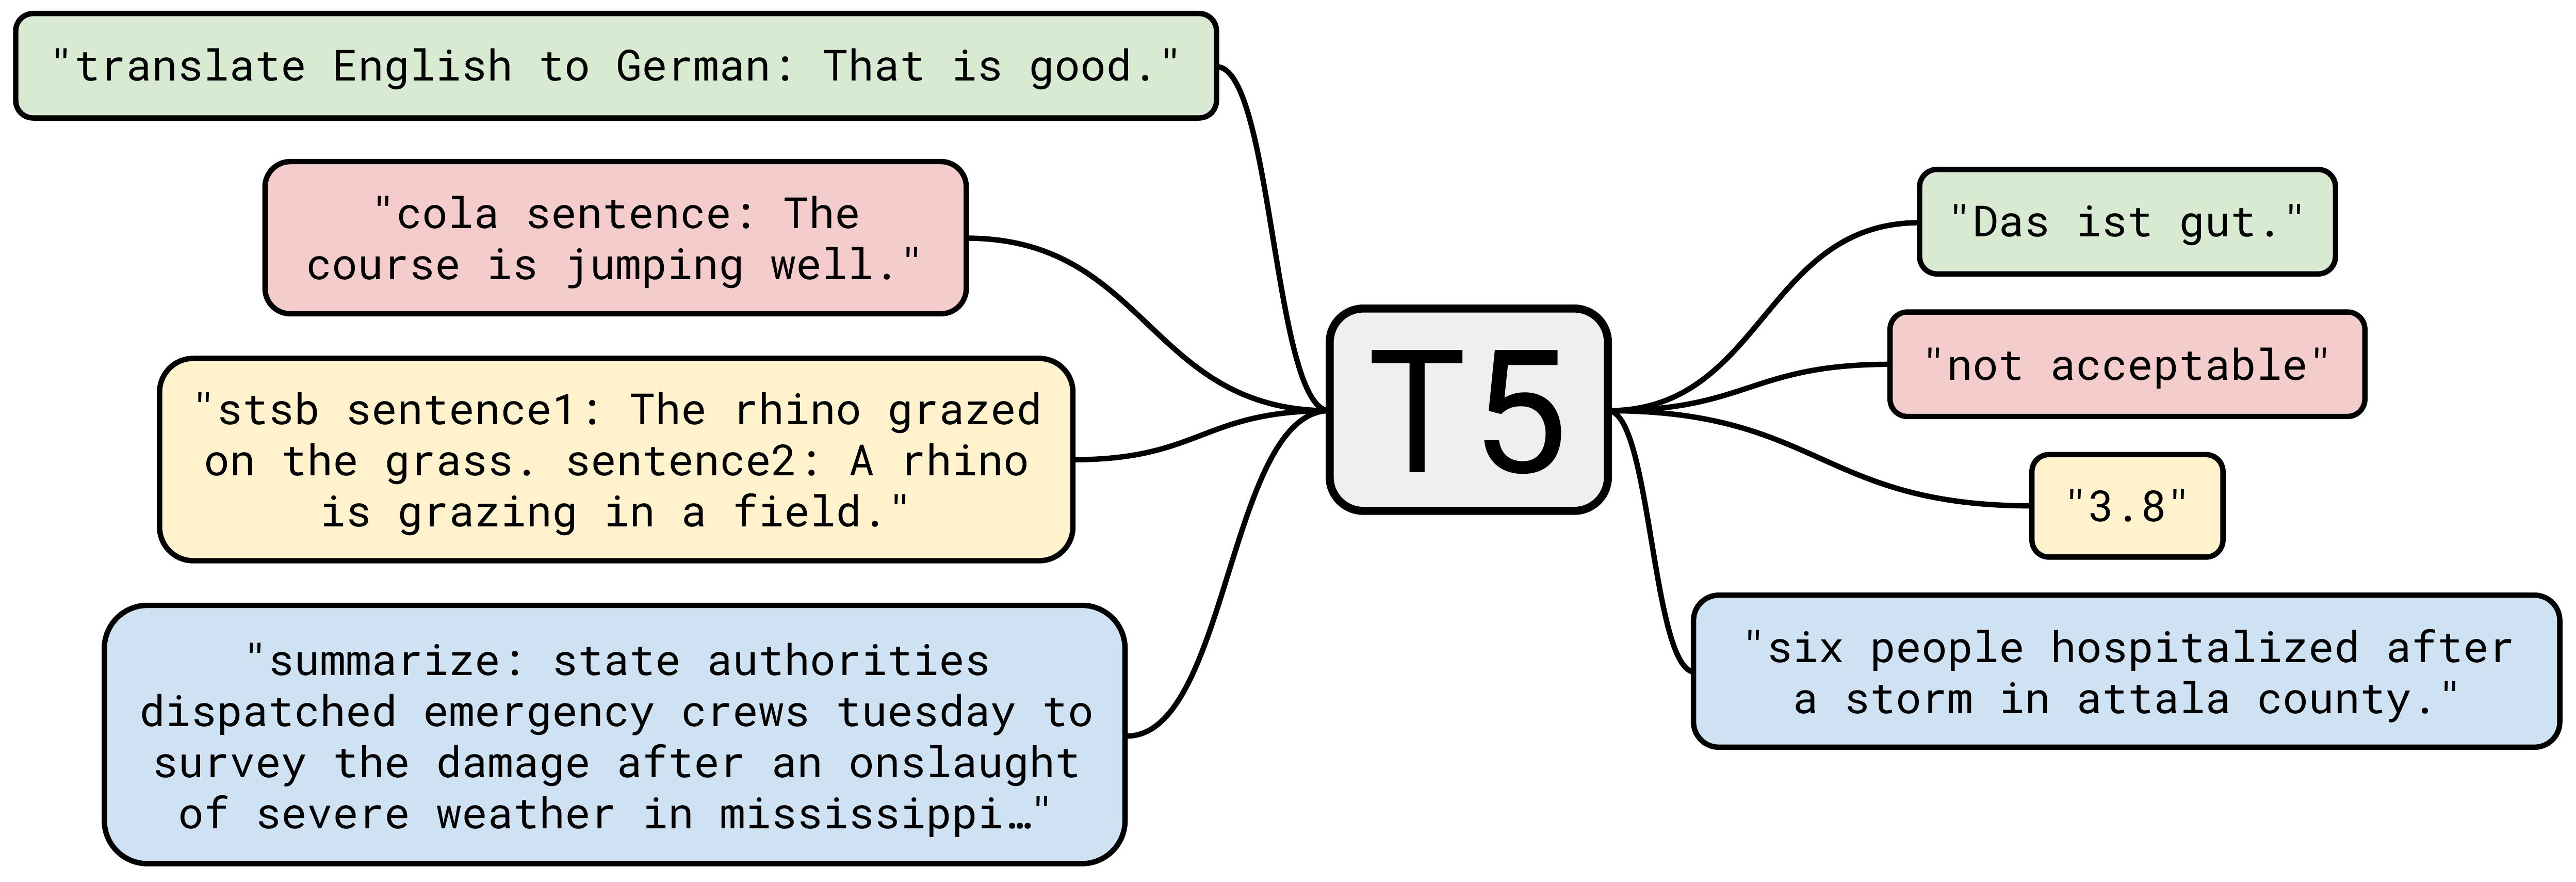

#### **Architecture of the T5 Model**
The architecture of T5 is based on the Transformer model, which consists of an encoder and a decoder. The encoder processes the input text, while the decoder generates the output text. Here are the main components of the T5 architecture:

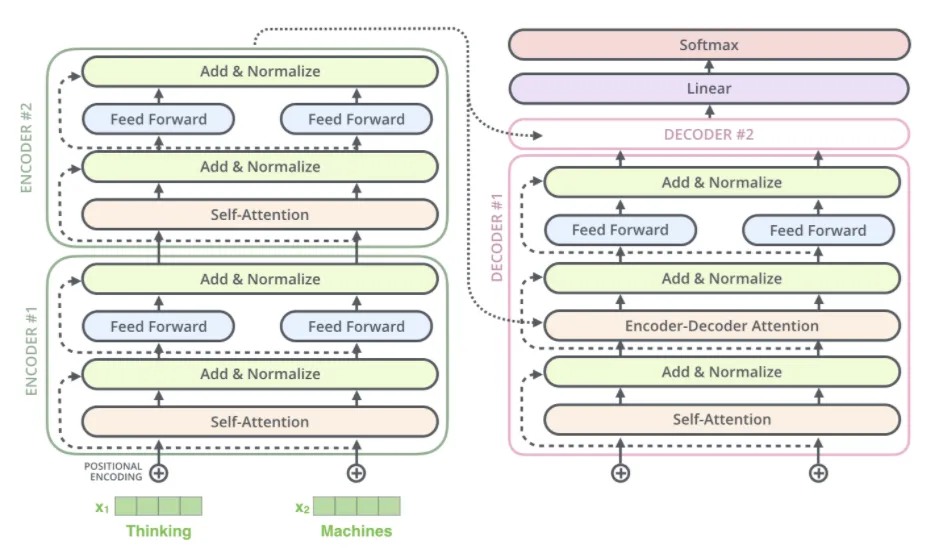

**Input Representation**

1. Tokenization:

 Uses SentencePiece, which creates a vocabulary of subword units. The input text is split into these subword tokens.

 For example, translate English to French: How are you? might be tokenized into: [ 'translate', '▁English', '▁to', '▁French', ':', '▁How', '▁are', '▁you', '?' ]

2. Conversion to Token IDs:

 Each token is mapped to a unique integer ID from the vocabulary.
3. Embedding:

 Token IDs are converted into dense vectors (embeddings).


 Positional embeddings are added to these token embeddings to encode the position of each token in the sequence.

**Encoder**

 The encoder is composed of multiple layers (e.g., 12 layers in T5-Base). Each layer consists of:

1. Self-Attention Mechanism:

 Allows each token to attend to all other tokens in the input sequence.
Multi-head attention is used, where multiple attention heads capture different aspects of the relationships between tokens.
2. Feed-Forward Neural Network (FFN):

 A two-layer fully connected network with a ReLU activation in between.
Typically includes dropout for regularization.
3. Layer Normalization:

 Applied before each sub-layer to stabilize training (pre-norm).
4. Residual Connections:

 Skip connections around each sub-layer ensures effective gradient flow during training.
**Decoder**

The decoder also consists of multiple layers (e.g., 12 layers in T5-Base). Each layer includes:

1. Self-Attention Mechanism:
 Similar to the encoder but with masking to prevent positions from attending to future positions in the output sequence.
2. Cross-Attention Mechanism:

 Allows each position in the decoder to attend to all positions in the encoder’s output.
3. Feed-Forward Neural Network (FFN):

 Similar to the encoder.
4. Layer Normalization:

 Applied before each sub-layer (pre-norm).
5. Residual Connections:

 Skip connections around each sub-layer.

The **T5** (Text-To-Text Transfer Transformer) model is a **large language model (LLM)** developed by **Google Research** in 2020, described in the paper:

> 📄 "**Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer**"
> [Colin Raffel et al., 2020 – Google Research](https://arxiv.org/abs/1910.10683)

---

## 🧠 What is T5?

**T5** stands for **Text-to-Text Transfer Transformer**. It treats **all NLP tasks** as a **text-to-text problem** — both the input and the output are always text strings.

---

## 🔧 Key Concepts of T5

### 🧩 1. **Unified Text-to-Text Framework**

Unlike models that are trained on specific tasks (like BERT for classification or GPT for generation), T5 **converts every NLP task into a text generation problem**.

| Task           | Input Format                                  | Output Format       |
| -------------- | --------------------------------------------- | ------------------- |
| Translation    | `"translate English to German: That is good"` | `"Das ist gut"`     |
| Summarization  | `"summarize: The article says..."`            | `"Summary of text"` |
| Classification | `"sst2 sentence: This movie was great"`       | `"positive"`        |
| QA             | `"question: Where is Paris? context: ..."`    | `"France"`          |

---

## 🏗️ Model Architecture

T5 is based on the **standard Transformer encoder-decoder architecture**, originally introduced in *"Attention is All You Need"* (Vaswani et al., 2017), but with some important adaptations:

| Component                        | Description                                                               |
| -------------------------------- | ------------------------------------------------------------------------- |
| **Encoder**                      | Processes the input sequence, generating contextual embeddings.           |
| **Decoder**                      | Autoregressively generates the output text token by token.                |
| **Feed-forward**                 | Uses layer norm before instead of after residual connections ("Pre-LN").  |
| **Relative Positional Encoding** | Uses **relative** position encodings (from Transformer-XL), not absolute. |
| **LayerNorm**                    | Applies **pre-normalization** (before attention and feed-forward layers). |

T5 comes in multiple sizes (number of parameters):

| Model Variant | # Layers | Hidden Size | FFN Size | # Heads | Params |
| ------------- | -------- | ----------- | -------- | ------- | ------ |
| T5-Small      | 6        | 512         | 2048     | 8       | \~60M  |
| T5-Base       | 12       | 768         | 3072     | 12      | \~220M |
| T5-Large      | 24       | 1024        | 4096     | 16      | \~770M |
| T5-3B         | 24       | 1024        | 16384    | 32      | \~3B   |
| T5-11B        | 24       | 1024        | 16384    | 32      | \~11B  |

---

## 📚 Pretraining Process

### Dataset: **C4 (Colossal Clean Crawled Corpus)**

* \~750 GB of cleaned English web text
* Preprocessing filters low-quality content (e.g., deduplication, script removal, profanity filtering)

---

### 🔁 Pretraining Task: **Span Corruption (Text Infilling)**

Rather than using a masked LM like BERT or causal LM like GPT, T5 uses **"span corruption"**:

1. Randomly sample **spans of text** (not individual tokens).
2. Replace each span with a unique **mask token** (`<extra_id_0>`, `<extra_id_1>`, etc.).
3. The model is trained to **generate the missing spans in order**.

**Example:**

```
Input:  "The <extra_id_0> sat on the <extra_id_1>."
Target: "<extra_id_0> cat <extra_id_1> mat <extra_id_2>"
```

This teaches the model:

* How to handle missing content
* To model both left and right context
* To understand sequential ordering of multiple spans

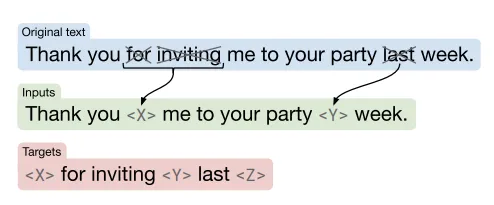

---

## 🔁 Fine-tuning

After pretraining on the span corruption task, T5 is **fine-tuned** on various downstream tasks (translation, QA, summarization, classification) using **task-specific prefixes** like:

* `"translate English to French: ..."`
* `"summarize: ..."`
* `"cola sentence: ..." (for grammaticality classification)`

The model learns to **understand the task based on textual instructions**.

---

## 🔍 T5 vs GPT vs BERT

| Feature                    | **T5**                                    | **GPT (e.g., GPT-2/3)**              | **BERT**                              |
| -------------------------- | ----------------------------------------- | ------------------------------------ | ------------------------------------- |
| **Architecture**           | Encoder-decoder (full Transformer)        | Decoder-only                         | Encoder-only                          |
| **Pretraining Objective**  | Span corruption (text infilling)          | Causal LM (next-token prediction)    | Masked LM (random token masking)      |
| **Task Format**            | Text-to-text (uniform input/output)       | Text-to-text (generation)            | Classification, QA, etc. (input only) |
| **Bidirectionality**       | Yes (encoder-decoder combines contexts)   | No (unidirectional)                  | Yes (masked tokens see both sides)    |
| **Use Cases**              | Versatile: translation, QA, summarization | Language generation, chat            | Classification, QA, embeddings        |
| **Instructional Prefixes** | Yes (task-specific prompts)               | No (until GPT-3-instruct/fine-tuned) | No                                    |
| **Open-source?**           | Yes (via Hugging Face)                    | GPT-2: Yes, GPT-3: No (API only)     | Yes                                   |

---

#### Summary

**T5 is a powerful, versatile LLM that:**

* Uses a **unified text-to-text format** for all NLP tasks.
* Is built on a **Transformer encoder-decoder** architecture.
* Was pretrained on **C4** using a **span corruption (text infilling)** task.
* Can be **fine-tuned** easily for tasks like summarization, translation, QA, and more.
* Bridges the strengths of **BERT's understanding** and **GPT's generation**.


## Using Pretrained T5 for Summarization without Fine-tuning


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d9f38c74a5d11fcd039cb84afd938c43b94926b30876f648436f3fef7a7ffa7f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import torch
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration
import evaluate

2025-05-25 22:55:21.166512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748213721.346424      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748213721.401831      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**dataset:**

Extreme Summarization (XSum) Dataset.

There are three features:

* document: Input news article.
* summary: One sentence summary of the article.
* id: BBC ID of the article.

In [ ]:
# Load small subset of XSum dataset
dataset = load_dataset("xsum", split="train[:100]")

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


(…)SUM-EMNLP18-Summary-Data-Original.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

load_dataset("xsum"): Loads the XSum dataset — a common benchmark for summarization.

split="train[:100]": Selects the first 100 training samples


In [ ]:
dataset

Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 100
})

In [ ]:
for i in range(3):
    print(f"\nSample {i+1}")
    print("Document:", dataset[i]["document"])
    print("Summary:", dataset[i]["summary"])


Sample 1
Document: The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate

In [ ]:
# Load T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Loads the T5-small model and tokenizer from Hugging Face.

T5 is a text-to-text transformer, trained to perform many tasks via prompts like "summarize: ...".

**Evaluation:**

In [ ]:
# ROUGE metric
evaluator = evaluate.load("rouge")

Loads the ROUGE metric using the 🤗 evaluate library.

ROUGE measures similarity between generated summaries and references (e.g., ROUGE-1, ROUGE-2, ROUGE-L).

In [ ]:
# Summarization with base model
def summarize(text):
    input_text = "summarize: " + text
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=64)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


#Evalaution LOOP
# Evaluate ROUGE
predictions = []
references = []

for sample in dataset:
    pred = summarize(sample["document"])
    ref = sample["summary"]
    predictions.append(pred)
    references.append(ref)

results = evaluator.compute(predictions=predictions, references=references)
print("\nBase T5 Summarization ROUGE Scores:")
print(results)


Base T5 Summarization ROUGE Scores:
{'rouge1': 0.18679996103263843, 'rouge2': 0.026180533382646823, 'rougeL': 0.13131298449835302, 'rougeLsum': 0.13105412407593786}


Prepares the input with the "summarize: " prefix (T5 was trained with prompts).

Tokenizes the input into tensors.

model.generate(...) does greedy or beam search to produce tokens.

Decodes the output tensor into readable text.

Iterates over the 100 documents.

For each:

pred: Model-generated summary.

ref: Ground-truth summary.

Stores both for ROUGE comparison.

Uses the ROUGE evaluator to score predictions vs. references.

Outputs scores like:

ROUGE-1: Overlap of unigrams

ROUGE-2: Overlap of bigrams

ROUGE-L: Longest common subsequence

In [ ]:
# Inference Example
print("\nInference Example:")
print("Input:", dataset[0]["document"])
print("Predicted Summary:", summarize(dataset[0]["document"]))


Inference Example:
Input: The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally app

In [ ]:
# Inference Example
print("\nInference Example:")
print("Input:", dataset[1]["document"])
print("Predicted Summary:", summarize(dataset[1]["document"]))


Inference Example:
Input: A fire alarm went off at the Holiday Inn in Hope Street at about 04:20 BST on Saturday and guests were asked to leave the hotel.
As they gathered outside they saw the two buses, parked side-by-side in the car park, engulfed by flames.
One of the tour groups is from Germany, the other from China and Taiwan. It was their first night in Northern Ireland.
The driver of one of the buses said many of the passengers had left personal belongings on board and these had been destroyed.
Both groups have organised replacement coaches and will begin their tour of the north coast later than they had planned.
Police have appealed for information about the attack.
Insp David Gibson said: "It appears as though the fire started under one of the buses before spreading to the second.
"While the exact cause is still under investigation, it is thought that the fire was started deliberately."
Predicted Summary: fire alarm went off at the Holiday Inn in Hope Street on Saturday. gues

### Prompt Tuning T5 Model for Summarization

In [ ]:
import torch
from torch import nn
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from datasets import load_dataset
from peft import PromptTuningConfig, PromptTuningInit, get_peft_model, TaskType
import torch

In [ ]:
# Load small subset of XSum dataset
dataset = load_dataset("xsum", split="train[:100]")

In [ ]:
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
base_model = T5ForConditionalGeneration.from_pretrained(model_name)

In [ ]:
#Preprocess Dataset
def preprocess(example):
    input_text = "summarize: " + example["document"]
    target_text = example["summary"]
    inputs = tokenizer(
        input_text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    targets = tokenizer(
        target_text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return {
        "input_ids": inputs["input_ids"].squeeze(),
        "attention_mask": inputs["attention_mask"].squeeze(),
        "labels": targets["input_ids"].squeeze(),
    }

dataset = dataset.map(preprocess)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
from peft import PromptTuningConfig, PromptTuningInit, get_peft_model, TaskType

# Prompt Tuning Configuration
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=10,
    prompt_tuning_init_text="summarize: ",
    tokenizer_name_or_path=model_name
)

# Wrap model with PEFT
model = get_peft_model(base_model, peft_config)


In [ ]:
print(model.print_trainable_parameters())



#### **Define Prompt Tuning Config**

```python
peft_config = PromptTuningConfig(...)
```

This creates a config object that tells PEFT how to **add and train virtual prompt tokens**. Let’s break down each parameter:

| Argument                                   | Description                                                                                                                                          |
| ------------------------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| `task_type=TaskType.SEQ_2_SEQ_LM`          | This tells PEFT that the underlying model is a **sequence-to-sequence language model** like T5.                                                      |
| `prompt_tuning_init=PromptTuningInit.TEXT` | This says we want to **initialize** the soft prompt embeddings using real token embeddings from some text.                                           |
| `num_virtual_tokens=10`                    | We'll insert 10 **soft prompt tokens** before the input — these are **trainable embeddings**, not real tokens.                                       |
| `prompt_tuning_init_text="summarize: "`    | This is the actual **initialization prompt text**. PEFT will tokenize this and use the corresponding token embeddings to initialize the soft prompt. |
| `tokenizer_name_or_path=model_name`        | Tokenizer to use (e.g., `"t5-small"`). PEFT uses this to tokenize the init text into token IDs.                                                      |

### What happens internally at this stage?

1. PEFT tokenizes `"summarize: "` using the tokenizer.
2. Converts it to token IDs like `[10990, 10]` (for example).
3. Looks up their embeddings in the base model’s embedding layer (`t5_model.shared`).
4. Uses these embeddings to initialize the **soft prompt embeddings**.

If the number of virtual tokens is larger than the number of init tokens (e.g., 10 virtual tokens from 2 tokens), then:

* It **repeats** the embedding vectors to fill the required size.
* Or interpolates/truncates as needed.

---

### **Apply PEFT to Base Model**

```python
model = get_peft_model(base_model, peft_config)
```

This function does the heavy lifting:

1. **Adds soft prompt embeddings** to the model input:

   * Prepends `10` trainable soft tokens to the input sequence.

2. Sets up only those embeddings to be trainable.
3. Leaves the base model **frozen** (unless you later unfreeze it manually).

> 🔁 During training, only the soft prompt embeddings get updated — **the base model remains unchanged.**



Below is a detailed explanation of how PEFT (and most soft‐prompt tuning implementations) take a short “initialization text” (e.g. `"summarize: "`) and expand it (“tile” or “interpolate”) into a larger block of **virtual prompt embeddings**, and then how those virtual embeddings are prepended to your real input embeddings in matrix form.

---

## 1. From Initialization Text → Token IDs → Embeddings

1. **Initialization text**:

   ```
   "summarize: "
   ```
2. **Tokenizer step** (T5 BPE, for instance) might split it into 2 tokens:

   ```
   ["summarize", ":"]
   ```
3. **Token IDs**:

   ```
   [i₁, i₂]  with i₁ = ID("summarize"), i₂ = ID(":")]
   ```
4. **Embedding lookup** via the base model’s embedding layer `E ∈ ℝ^(V×D)`:

   ```
   e₁ = E[i₁]    ∈ ℝ^D  
   e₂ = E[i₂]    ∈ ℝ^D  
   ```

   Together that gives a matrix `E_init ∈ ℝ^(2×D)`:

   ```
   E_init = [ e₁
              e₂ ]
   ```

---

## 2. Expanding to N Virtual Tokens

You choose a hyperparameter `P = num_virtual_tokens` (e.g. 10). You need a matrix

```
P_prompt ∈ ℝ^(P×D)
```

to serve as your **soft prompt**. PEFT “tiles” (repeats) or otherwise **broadcasts** the small 2×D matrix into a P×D matrix. The simplest strategy is **tiling in sequence**:

1. **Repeat** `e₁, e₂` in order until you have `P` rows.
2. **Truncate** any extra if `2` does not divide `P` evenly.

### Example: P = 10, init tokens = 2

Tile pattern:

```
[e₁, e₂, e₁, e₂, e₁, e₂, e₁, e₂, e₁, e₂]   → 10 vectors
```

So your virtual prompt matrix looks like:

$$
P_{\text{prompt}} =
\begin{bmatrix}
e_1 \\[6pt]
e_2 \\[6pt]
e_1 \\[6pt]
e_2 \\[6pt]
e_1 \\[6pt]
e_2 \\[6pt]
e_1 \\[6pt]
e_2 \\[6pt]
e_1 \\[6pt]
e_2
\end{bmatrix}
\in \mathbb{R}^{10 \times D}
$$

---

## 3. Prepending to Real Input Embeddings

Assume your real input (after tokenization) has length $L$ tokens:

```
Tokens:  [t₁, t₂, …, t_L]
Embeds:  [E[t₁]; E[t₂]; …; E[t_L]]   ∈ ℝ^(L×D)
```

You **concatenate** the virtual prompt embeddings on the “time” (row) axis *before* the real input embeddings:

$$
\underbrace{
\begin{bmatrix}
\color{gray}P_{\text{prompt}}\\\hline
E[t_1]\\
E[t_2]\\
\vdots\\
E[t_L]
\end{bmatrix}
}_{\displaystyle \in \mathbb{R}^{(P + L)\times D}}
$$

– The top $P$ rows are your learnable soft prompts.
– The bottom $L$ rows are the actual token embeddings of your input.

Concretely in block‐matrix form:

```
 [  P_prompt  ]   shape: (P, D)
 [  E[input] ]   shape: (L, D)
```

→ Concatenate → shape $(P+L, D)$.

---

### Why This Matters

* The Transformer’s self-attention will attend over these $P$ soft tokens **and** the real tokens, allowing the model to condition its entire encoding/decoding on the “learned instruction” held in those prompt vectors.
* Only the $P$ soft-prompt vectors are updated during training; the rest of the model stays frozen.

---

### Key Takeaways

* **`prompt_tuning_init_text`** seeds a small embedding matrix `E_init ∈ ℝ^(M×D)` (here $M=2$).
* That matrix is **tiled** to become `P_prompt ∈ ℝ^(P×D)` (here $P=10$).
* You **prepend** `P_prompt` to your real input embeddings, yielding a combined sequence embedding of length $P + L$.

This mechanism lets you inject a learned “prefix” into the model without ever modifying the main Transformer weights.


In [ ]:
from transformers import TrainingArguments
from transformers import Trainer

# Freezes all parameters in the original T5 — only prompt tokens will be trained.
for param in model.base_model.parameters():
    param.requires_grad = False

# Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    num_train_epochs=10,
    logging_steps=10,
    learning_rate=1e-3,
    remove_unused_columns=False,
    report_to="none",
    save_strategy="no"
)

# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Train Model
trainer.train()

# Save Model Correctly (prevents shared tensor error)
trainer.save_model("./results")  # includes both base and soft prompts
tokenizer.save_pretrained("./results")

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/spiece.model',
 './results/added_tokens.json')

Below is a description of exactly what happens when you train only the soft prompt embeddings in prompt tuning, showing how gradients flow and why only those embeddings get updated. I’ll use concise notation to make each step crystal‐clear.


## 1. Notation and Setup

* Let $D$ be the model’s hidden dimension (e.g. 768).
* Let $P$ be the number of **virtual prompt tokens** (e.g. 10).
* Let $L$ be the length of the real input sequence (in tokens).
* Let $\mathbf{E}\colon \{1,\dots,V\}\to\mathbb{R}^D$ be the frozen word‐embedding lookup from the pretrained model.
* Let $\mathbf{P}\in\mathbb{R}^{P\times D}$ be the **soft prompt embedding matrix**, our only trainable parameters.
* Let $\mathbf{X}\in\mathbb{R}^{L\times D}$ be the **real input embeddings** (frozen), obtained by lookup $\mathbf{E}(x_i)$.
* Let $f_\theta$ be the rest of the (frozen) Transformer and head, parameterized by $\theta$, mapping a sequence of embeddings in $\mathbb{R}^{(P+L)\times D}$ to output logits.

We define the **combined input** to the model as the concatenation of $\mathbf{P}$ and $\mathbf{X}$:

$$
\mathbf{H}^{(0)}
= \begin{bmatrix} \mathbf{P} \\[6pt] \mathbf{X} \end{bmatrix}
\quad\in\mathbb{R}^{(P+L)\times D}.
$$

---

## 2. Forward Pass

1. **Positional Encoding & Attention Layers**
   Transformer layers successively transform $\mathbf{H}^{(0)}$ through self‐attention and feedforward blocks. At each layer $k$:

   $$
   \mathbf{H}^{(k)} = \text{TransformerLayer}_k\bigl(\mathbf{H}^{(k-1)}\bigr),
   $$

   with $\mathbf{H}^{(0)}$ as above. All weights in these layers are **frozen**.

2. **Output & Loss**
   The final hidden states $\mathbf{H}^{(N)}$ (where $N$ is the number of layers) go into a linear + softmax head to produce token‐wise probability distributions $\hat y_t$. We compute a standard cross‐entropy loss against the true target tokens $\{y_t\}_{t=1}^{P+L}$:

   $$
   \mathcal{L} \;=\; -\sum_{t=1}^{P+L} \log \hat y_t\bigl(y_t\bigr).
   $$

---

## 3. Backward Pass (Gradient Flow)

We want $\displaystyle \frac{\partial \mathcal{L}}{\partial \mathbf{P}}$. Notice:

* **Frozen parameters** $\theta$ have $\partial \mathcal{L}/\partial\theta = 0$.
* $\mathbf{X}$ is also frozen (no gradient flows into $\mathbf{E}$ or the tokenizer).

Only $\mathbf{P}$ has $\text{requires\_grad} = \text{True}$.

By the chain rule:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{P}}
=
\frac{\partial \mathcal{L}}{\partial \mathbf{H}^{(0)}}
\;\cdot\;
\frac{\partial \mathbf{H}^{(0)}}{\partial \mathbf{P}}
$$

But
$\displaystyle \mathbf{H}^{(0)} = \begin{bmatrix} \mathbf{P} \\ \mathbf{X} \end{bmatrix}$, so

$$
\frac{\partial \mathbf{H}^{(0)}}{\partial \mathbf{P}}
=
\begin{bmatrix} \mathbf{I}_{P\times P} \\ \mathbf{0}_{L \times P} \end{bmatrix},
$$

which simply means the gradient wrt $\mathbf{H}^{(0)}$ in its first $P$ rows directly becomes the gradient wrt $\mathbf{P}$.

Concretely, if we write
$\nabla_{\mathbf{H}^{(0)}}\mathcal{L}\in\mathbb{R}^{(P+L)\times D}$,
then the **top** $P$ rows are exactly $\nabla_{\mathbf{P}}\mathcal{L}$.

---

## 4. Parameter Update

Using gradient descent (or Adam, etc.), we update:

$$
\mathbf{P} \;\leftarrow\; \mathbf{P}
\;-\;\eta\;\nabla_{\mathbf{P}} \mathcal{L},
$$

where $\eta$ is the learning rate. Since $\nabla_{\mathbf{P}} \mathcal{L}$ comes only from the **first** $P$ rows of \\


**Evaluation:**

In [ ]:
import evaluate
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
from peft import PeftModel, PeftConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Reload Prompt-Tuned Model for Inference
peft_dir = "./results"
peft_cfg = PeftConfig.from_pretrained(peft_dir)
base = T5ForConditionalGeneration.from_pretrained(peft_cfg.base_model_name_or_path)
model = PeftModel.from_pretrained(base, peft_dir).to(device)
model.eval()

# Load tokenizer
tokenizer = T5Tokenizer.from_pretrained(peft_dir)

# Load ROUGE
rouge = evaluate.load("rouge")
evaluator = evaluate.load("rouge")

# Load eval dataset
dataset = load_dataset("xsum", split="test[:100]")

preds, refs = [], []
for ex in dataset:
    text = "summarize: " + ex["document"]
    toks = tokenizer(text, return_tensors="pt", padding="max_length",
                     truncation=True, max_length=512).to(device)

    # generate with prompt‐tuned model
    out_ids = model.generate(
        input_ids=toks["input_ids"],
        attention_mask=toks["attention_mask"],
        max_new_tokens=128,
        num_beams=4,
        early_stopping=True,
    )
    summary = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    preds.append(summary)
    refs.append(ex["summary"])

# Compute ROUGE via your evaluator
scores = evaluator.compute(predictions=preds, references=refs)
print(f"ROUGE-1: {scores['rouge1']:.4f}")
print(f"ROUGE-2: {scores['rouge2']:.4f}")
print(f"ROUGE-L: {scores['rougeL']:.4f}")


ROUGE-1: 0.1859
ROUGE-2: 0.0280
ROUGE-L: 0.1353


**Inference:**

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from peft import PeftModel, PeftConfig
from datasets import load_dataset

# 1. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load the PEFT config and base T5 model
peft_dir = "./results"
peft_config = PeftConfig.from_pretrained(peft_dir)
base_model = T5ForConditionalGeneration.from_pretrained(peft_config.base_model_name_or_path)

# 3. Wrap base model with learned soft prompts
model = PeftModel.from_pretrained(base_model, peft_dir).to(device)
model.eval()

# 4. Load the tokenizer (same as before)
tokenizer = T5Tokenizer.from_pretrained(peft_dir)

# 5. (Optional) Load the dataset to grab docs 0 and 1
dataset = load_dataset("xsum", split="train[:100]")

# 6. Inference function
def summarize_prompt_tuned(text):
    # Prepare input
    input_text = "summarize: " + text
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    # Generate
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=128,
            num_beams=4,
            early_stopping=True
        )

    # Decode
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# 7. Run on dataset[0] and dataset[1]
for idx in [0, 1]:
    doc = dataset[idx]["document"]
    print(f"\n=== Document {idx} ===\n{doc}\n")
    summary = summarize_prompt_tuned(doc)
    print(f"--- Prompt-Tuned Summary {idx} ---\n{summary}\n")



=== Document 0 ===
The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate

**Comparison:**

* Base-model Summary 0:


  * repairs are ongoing in the area and many roads in peeblesshire remain badly affected. the full cost of damage in Newton Stewart is still being assessed. the water breached a retaining wall, flooding many commercial properties.

* Prompt-Tuned Summary 0:

  * many businesses and householders affected by flooding in peeblesshire. the water breached a retaining wall, flooding many commercial properties. a flood alert remains in place across the border due to the constant rain.

  


* Base-model Summary 1:

   * fire alarm went off at the Holiday Inn in Hope Street on Saturday. guests were asked to leave the hotel. one of the two buses is from germany, the other from china and Taiwan.
* Prompt-Tuned Summary 1:

  * a fire alarm went off at the Holiday Inn in Hope Street, northern Ireland. the driver said many of the passengers had left personal belongings on board. police have appealed for information about the attack.

# **Third Example:**

#### In third part we want to classify whether a tweet is a complaint or not, using prompt-tuning.

In [ ]:
from transformers import AutoModelForCausalLM
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType
import torch
from datasets import load_dataset
import os
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
from datasets import load_dataset

In [ ]:
device = "cuda"

In [ ]:
model_name_or_path = "bigscience/bloomz-560m"
tokenizer_name_or_path = "bigscience/bloomz-560m"

In [ ]:
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=8,
    prompt_tuning_init_text="Classify if the tweet is a complaint or not:",
    tokenizer_name_or_path=model_name_or_path,
)

In [ ]:
dataset_name = "twitter_complaints"

checkpoint_name = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}_v1.pt".replace(
    "/", "_"
)

text_column = "Tweet text"
label_column = "text_label"


max_length = 64
lr = 3e-2
num_epochs = 50
batch_size = 8

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ought/raft", dataset_name)

classes = [k.replace("_", " ") for k in dataset["train"].features["Label"].names]
print(classes)
dataset = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["Label"]]},
    batched=True,
    num_proc=1,
)
print(dataset)
dataset["train"][0]

In [ ]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
target_max_length = max([len(tokenizer(class_label)["input_ids"]) for class_label in classes])
print(target_max_length)


def preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x} Label : " for x in examples[text_column]]
    targets = [str(x) for x in examples[label_column]]
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets, add_special_tokens=False)  # don't add bos token because we concatenate with inputs
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.eos_token_id]
        # print(i, sample_input_ids, label_input_ids)
        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["train"]


train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

In [ ]:
def test_preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x} Label : " for x in examples[text_column]]
    model_inputs = tokenizer(inputs)
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
    return model_inputs


test_dataset = dataset["test"].map(
    test_preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

test_dataloader = DataLoader(test_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)
next(iter(test_dataloader))

In [ ]:
next(iter(train_dataloader))

In [ ]:
len(test_dataloader)

In [ ]:
next(iter(test_dataloader))

In [ ]:
# creating model
model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

In [ ]:
# model
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [ ]:
# training and evaluation
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        #         print(batch)
        #         print(batch["input_ids"].shape)
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.48it/s]


epoch=0: train_ppl=tensor(2.2720e+13, device='cuda:0') train_epoch_loss=tensor(30.7543, device='cuda:0') eval_ppl=tensor(483597.5625, device='cuda:0') eval_epoch_loss=tensor(13.0890, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20.96it/s]


epoch=1: train_ppl=tensor(452658.3750, device='cuda:0') train_epoch_loss=tensor(13.0229, device='cuda:0') eval_ppl=tensor(275088.1875, device='cuda:0') eval_epoch_loss=tensor(12.5248, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.41it/s]


epoch=2: train_ppl=tensor(199203.3906, device='cuda:0') train_epoch_loss=tensor(12.2021, device='cuda:0') eval_ppl=tensor(143637.0312, device='cuda:0') eval_epoch_loss=tensor(11.8750, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.31it/s]


epoch=3: train_ppl=tensor(114743.9531, device='cuda:0') train_epoch_loss=tensor(11.6505, device='cuda:0') eval_ppl=tensor(54962., device='cuda:0') eval_epoch_loss=tensor(10.9144, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.34it/s]


epoch=4: train_ppl=tensor(40786.5977, device='cuda:0') train_epoch_loss=tensor(10.6161, device='cuda:0') eval_ppl=tensor(18342.5430, device='cuda:0') eval_epoch_loss=tensor(9.8170, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.34it/s]


epoch=5: train_ppl=tensor(14023.0830, device='cuda:0') train_epoch_loss=tensor(9.5485, device='cuda:0') eval_ppl=tensor(6316.8540, device='cuda:0') eval_epoch_loss=tensor(8.7510, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.32it/s]


epoch=6: train_ppl=tensor(5635.3262, device='cuda:0') train_epoch_loss=tensor(8.6368, device='cuda:0') eval_ppl=tensor(2476.5776, device='cuda:0') eval_epoch_loss=tensor(7.8146, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.30it/s]


epoch=7: train_ppl=tensor(1818.4940, device='cuda:0') train_epoch_loss=tensor(7.5058, device='cuda:0') eval_ppl=tensor(934.1146, device='cuda:0') eval_epoch_loss=tensor(6.8396, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 18.97it/s]


epoch=8: train_ppl=tensor(645.2143, device='cuda:0') train_epoch_loss=tensor(6.4696, device='cuda:0') eval_ppl=tensor(361.9093, device='cuda:0') eval_epoch_loss=tensor(5.8914, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.12it/s]


epoch=9: train_ppl=tensor(293.8047, device='cuda:0') train_epoch_loss=tensor(5.6829, device='cuda:0') eval_ppl=tensor(215.8185, device='cuda:0') eval_epoch_loss=tensor(5.3744, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20.83it/s]


epoch=10: train_ppl=tensor(191.2377, device='cuda:0') train_epoch_loss=tensor(5.2535, device='cuda:0') eval_ppl=tensor(177.1512, device='cuda:0') eval_epoch_loss=tensor(5.1770, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 18.98it/s]


epoch=11: train_ppl=tensor(153.6052, device='cuda:0') train_epoch_loss=tensor(5.0344, device='cuda:0') eval_ppl=tensor(126.6154, device='cuda:0') eval_epoch_loss=tensor(4.8412, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 18.78it/s]


epoch=12: train_ppl=tensor(122.8925, device='cuda:0') train_epoch_loss=tensor(4.8113, device='cuda:0') eval_ppl=tensor(97.3331, device='cuda:0') eval_epoch_loss=tensor(4.5781, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.72it/s]


epoch=13: train_ppl=tensor(84.8845, device='cuda:0') train_epoch_loss=tensor(4.4413, device='cuda:0') eval_ppl=tensor(70.3213, device='cuda:0') eval_epoch_loss=tensor(4.2531, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.07it/s]


epoch=14: train_ppl=tensor(64.6705, device='cuda:0') train_epoch_loss=tensor(4.1693, device='cuda:0') eval_ppl=tensor(50.4688, device='cuda:0') eval_epoch_loss=tensor(3.9214, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.63it/s]


epoch=15: train_ppl=tensor(44.2937, device='cuda:0') train_epoch_loss=tensor(3.7908, device='cuda:0') eval_ppl=tensor(34.8210, device='cuda:0') eval_epoch_loss=tensor(3.5502, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.67it/s]


epoch=16: train_ppl=tensor(30.0995, device='cuda:0') train_epoch_loss=tensor(3.4045, device='cuda:0') eval_ppl=tensor(24.7703, device='cuda:0') eval_epoch_loss=tensor(3.2096, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.59it/s]


epoch=17: train_ppl=tensor(23.3086, device='cuda:0') train_epoch_loss=tensor(3.1488, device='cuda:0') eval_ppl=tensor(20.8131, device='cuda:0') eval_epoch_loss=tensor(3.0356, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.04it/s]


epoch=18: train_ppl=tensor(16.4479, device='cuda:0') train_epoch_loss=tensor(2.8002, device='cuda:0') eval_ppl=tensor(12.0876, device='cuda:0') eval_epoch_loss=tensor(2.4922, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.37it/s]


epoch=19: train_ppl=tensor(11.1977, device='cuda:0') train_epoch_loss=tensor(2.4157, device='cuda:0') eval_ppl=tensor(9.0399, device='cuda:0') eval_epoch_loss=tensor(2.2016, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 17.29it/s]


epoch=20: train_ppl=tensor(8.1847, device='cuda:0') train_epoch_loss=tensor(2.1023, device='cuda:0') eval_ppl=tensor(6.7486, device='cuda:0') eval_epoch_loss=tensor(1.9093, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.58it/s]


epoch=21: train_ppl=tensor(6.1145, device='cuda:0') train_epoch_loss=tensor(1.8107, device='cuda:0') eval_ppl=tensor(5.5931, device='cuda:0') eval_epoch_loss=tensor(1.7215, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.36it/s]


epoch=22: train_ppl=tensor(5.2963, device='cuda:0') train_epoch_loss=tensor(1.6670, device='cuda:0') eval_ppl=tensor(5.0573, device='cuda:0') eval_epoch_loss=tensor(1.6208, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.26it/s]


epoch=23: train_ppl=tensor(4.7485, device='cuda:0') train_epoch_loss=tensor(1.5578, device='cuda:0') eval_ppl=tensor(3.6277, device='cuda:0') eval_epoch_loss=tensor(1.2886, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.31it/s]


epoch=24: train_ppl=tensor(3.4080, device='cuda:0') train_epoch_loss=tensor(1.2261, device='cuda:0') eval_ppl=tensor(3.0467, device='cuda:0') eval_epoch_loss=tensor(1.1141, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.25it/s]


epoch=25: train_ppl=tensor(3.3052, device='cuda:0') train_epoch_loss=tensor(1.1955, device='cuda:0') eval_ppl=tensor(2.7784, device='cuda:0') eval_epoch_loss=tensor(1.0219, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.22it/s]


epoch=26: train_ppl=tensor(2.9487, device='cuda:0') train_epoch_loss=tensor(1.0814, device='cuda:0') eval_ppl=tensor(2.9471, device='cuda:0') eval_epoch_loss=tensor(1.0808, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.25it/s]


epoch=27: train_ppl=tensor(2.8738, device='cuda:0') train_epoch_loss=tensor(1.0556, device='cuda:0') eval_ppl=tensor(2.5801, device='cuda:0') eval_epoch_loss=tensor(0.9478, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.28it/s]


epoch=28: train_ppl=tensor(2.3241, device='cuda:0') train_epoch_loss=tensor(0.8433, device='cuda:0') eval_ppl=tensor(2.2198, device='cuda:0') eval_epoch_loss=tensor(0.7974, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20.89it/s]


epoch=29: train_ppl=tensor(2.0376, device='cuda:0') train_epoch_loss=tensor(0.7118, device='cuda:0') eval_ppl=tensor(1.8572, device='cuda:0') eval_epoch_loss=tensor(0.6191, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 18.83it/s]


epoch=30: train_ppl=tensor(1.8301, device='cuda:0') train_epoch_loss=tensor(0.6044, device='cuda:0') eval_ppl=tensor(1.8864, device='cuda:0') eval_epoch_loss=tensor(0.6347, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.81it/s]


epoch=31: train_ppl=tensor(1.7301, device='cuda:0') train_epoch_loss=tensor(0.5482, device='cuda:0') eval_ppl=tensor(1.6340, device='cuda:0') eval_epoch_loss=tensor(0.4910, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.11it/s]


epoch=32: train_ppl=tensor(1.5842, device='cuda:0') train_epoch_loss=tensor(0.4601, device='cuda:0') eval_ppl=tensor(1.6179, device='cuda:0') eval_epoch_loss=tensor(0.4811, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 18.35it/s]


epoch=33: train_ppl=tensor(1.5193, device='cuda:0') train_epoch_loss=tensor(0.4183, device='cuda:0') eval_ppl=tensor(1.5543, device='cuda:0') eval_epoch_loss=tensor(0.4410, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 18.60it/s]


epoch=34: train_ppl=tensor(1.5402, device='cuda:0') train_epoch_loss=tensor(0.4319, device='cuda:0') eval_ppl=tensor(1.4924, device='cuda:0') eval_epoch_loss=tensor(0.4004, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.63it/s]


epoch=35: train_ppl=tensor(1.4410, device='cuda:0') train_epoch_loss=tensor(0.3654, device='cuda:0') eval_ppl=tensor(1.3888, device='cuda:0') eval_epoch_loss=tensor(0.3284, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.36it/s]


epoch=36: train_ppl=tensor(1.3675, device='cuda:0') train_epoch_loss=tensor(0.3130, device='cuda:0') eval_ppl=tensor(1.4001, device='cuda:0') eval_epoch_loss=tensor(0.3366, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.58it/s]


epoch=37: train_ppl=tensor(1.4197, device='cuda:0') train_epoch_loss=tensor(0.3505, device='cuda:0') eval_ppl=tensor(1.3214, device='cuda:0') eval_epoch_loss=tensor(0.2787, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]


epoch=38: train_ppl=tensor(1.3855, device='cuda:0') train_epoch_loss=tensor(0.3261, device='cuda:0') eval_ppl=tensor(1.3501, device='cuda:0') eval_epoch_loss=tensor(0.3001, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.57it/s]


epoch=39: train_ppl=tensor(1.3643, device='cuda:0') train_epoch_loss=tensor(0.3107, device='cuda:0') eval_ppl=tensor(1.3549, device='cuda:0') eval_epoch_loss=tensor(0.3037, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.41it/s]


epoch=40: train_ppl=tensor(1.3093, device='cuda:0') train_epoch_loss=tensor(0.2695, device='cuda:0') eval_ppl=tensor(1.3233, device='cuda:0') eval_epoch_loss=tensor(0.2801, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.51it/s]


epoch=41: train_ppl=tensor(1.3108, device='cuda:0') train_epoch_loss=tensor(0.2706, device='cuda:0') eval_ppl=tensor(1.3440, device='cuda:0') eval_epoch_loss=tensor(0.2957, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.61it/s]


epoch=42: train_ppl=tensor(1.2944, device='cuda:0') train_epoch_loss=tensor(0.2581, device='cuda:0') eval_ppl=tensor(1.2711, device='cuda:0') eval_epoch_loss=tensor(0.2399, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.56it/s]


epoch=43: train_ppl=tensor(1.2616, device='cuda:0') train_epoch_loss=tensor(0.2323, device='cuda:0') eval_ppl=tensor(1.2449, device='cuda:0') eval_epoch_loss=tensor(0.2190, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.27it/s]


epoch=44: train_ppl=tensor(1.2478, device='cuda:0') train_epoch_loss=tensor(0.2214, device='cuda:0') eval_ppl=tensor(1.2202, device='cuda:0') eval_epoch_loss=tensor(0.1990, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.31it/s]


epoch=45: train_ppl=tensor(1.2350, device='cuda:0') train_epoch_loss=tensor(0.2111, device='cuda:0') eval_ppl=tensor(1.2180, device='cuda:0') eval_epoch_loss=tensor(0.1972, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.33it/s]


epoch=46: train_ppl=tensor(1.2277, device='cuda:0') train_epoch_loss=tensor(0.2052, device='cuda:0') eval_ppl=tensor(1.2077, device='cuda:0') eval_epoch_loss=tensor(0.1887, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.35it/s]


epoch=47: train_ppl=tensor(1.2037, device='cuda:0') train_epoch_loss=tensor(0.1854, device='cuda:0') eval_ppl=tensor(1.2041, device='cuda:0') eval_epoch_loss=tensor(0.1857, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.29it/s]


epoch=48: train_ppl=tensor(1.2026, device='cuda:0') train_epoch_loss=tensor(0.1845, device='cuda:0') eval_ppl=tensor(1.1982, device='cuda:0') eval_epoch_loss=tensor(0.1808, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.35it/s]

epoch=49: train_ppl=tensor(1.2005, device='cuda:0') train_epoch_loss=tensor(0.1827, device='cuda:0') eval_ppl=tensor(1.1968, device='cuda:0') eval_epoch_loss=tensor(0.1796, device='cuda:0')


In [ ]:
model.eval()
i = 33
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]} Label : ', return_tensors="pt")
print(dataset["test"][i]["Tweet text"])
print(inputs)

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10, eos_token_id=3
    )
    print(outputs)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

@TommyHilfiger Dramatic shopping exp. ordered 6 jeans same size (30/32) 2 fits / 2 too large / 2 too slim : same brand &gt; different sizing
{'input_ids': tensor([[227985,   5484,    915,   2566, 226154, 126015,   5385,    259, 239364,
           3396,  70823,   5853,     17,  57247,   1231, 191040,   5025,   7869,
            375,   2324, 149349,     12,    415, 122321,    897,    415,  10136,
          10021,    897,    415,  10136,   6497,    381,    915,   5025,  51950,
          66869,   5955,    272,  20311,  77658,    915,    210]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[227985,   5484,    915,   2566, 226154, 126015,   5385,    259, 239364,
           3396,  70823,   5853,     17,  57247,   1231, 191040,   5025,   7869,
            375,   2324, 149349,     12,    415, 122321,    897,    415,  10136,
          10021,    897,    415,  10136,  

You can push model to hub or save model locally.

- Option1: Pushing the model to Hugging Face Hub
```python
model.push_to_hub(
    f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}".replace("/", "_"),
    token = "hf_..."
)
```
token (`bool` or `str`, *optional*):
    `token` is to be used for HTTP Bearer authorization when accessing remote files. If `True`, will use the token generated
    when running `huggingface-cli login` (stored in `~/.huggingface`). Will default to `True` if `repo_url`
    is not specified.
    Or you can get your token from https://huggingface.co/settings/token
```
- Or save model locally
```python
peft_model_id = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}".replace("/", "_")
model.save_pretrained(peft_model_id)
```

In [ ]:
# saving model
peft_model_id = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}".replace(
    "/", "_"
)
model.save_pretrained(peft_model_id)

In [ ]:
ckpt = f"{peft_model_id}/adapter_model.bin"
!du -h $ckpt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
36K	bigscience/bloomz-560m_PROMPT_TUNING_CAUSAL_LM/adapter_model.bin


In [ ]:
from peft import PeftModel, PeftConfig

peft_model_id = f"{dataset_name}_{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}".replace(
    "/", "_"
)

config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, peft_model_id)

In [ ]:
model.to(device)
model.eval()
i = 4
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]} Label : ', return_tensors="pt")
print(dataset["test"][i]["Tweet text"])
print(inputs)

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10, eos_token_id=3
    )
    print(outputs)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

@greateranglia Ok thanks...
{'input_ids': tensor([[227985,   5484,    915,   2566,  14173,   2960,  29906,    387,  20706,
          49337,   1369,  77658,    915,    210]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[227985,   5484,    915,   2566,  14173,   2960,  29906,    387,  20706,
          49337,   1369,  77658,    915,    210,   1936, 106863,      3]],
       device='cuda:0')
['Tweet text : @greateranglia Ok thanks... Label : no complaint']
